# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [54]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

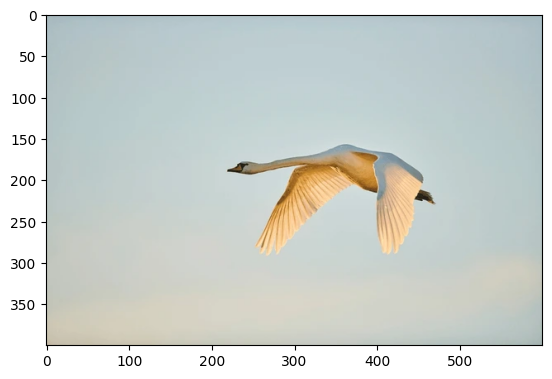

In [55]:
### START CODE HERE ###
image = cv2.imread("./image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

Text(0.5, 1.0, 'HOG')

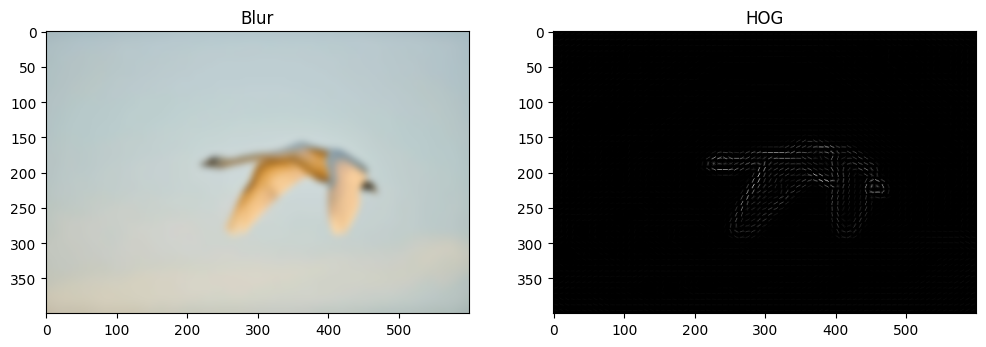

In [56]:
### START CODE HERE ###
blurry_image = cv2.GaussianBlur(np.array(image), (25, 25), 5)
fd, hog_image = hog(
    blurry_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=-1
)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(blurry_image)
axs[0].set_title('Blur')

axs[1].imshow(hog_image, cmap='gray')
axs[1].set_title('HOG')


### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [57]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.hGrid = np.arange(0, self.h - self.tile_size[0] + 1, self.stride)
        self.wGrid = np.arange(0, self.w - self.tile_size[1] + 1, self.stride)
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        self.hog_features = []
        self.hog_images = []
        for i in self.hGrid:
            for j in self.wGrid:
                sub_img = self.image[i:i+self.tile_size[0], j:j+self.tile_size[1]]
                fd, hog_img = hog(
                    sub_img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4),
                    visualize=True,
                    channel_axis=-1
                )
                self.hog_features.append(fd)
                self.hog_images.append(hog_img)
        

    def plot_hog_images(self):
        num_rows = len(self.hGrid)
        num_cols = len(self.wGrid)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))
        axs = np.array(axs).reshape(num_rows, num_cols)
        for idx, hog_img in enumerate(self.hog_images):
            row = idx // num_cols
            col = idx % num_cols
            axs[row, col].imshow(hog_img, cmap='gray')
            axs[row, col].axis('off')
        plt.tight_layout()
        plt.show()
        

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

In [58]:
### START CODE HERE ###
tile_size = (64, 64)
stride = 16
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


Number of grids: (22, 34)


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

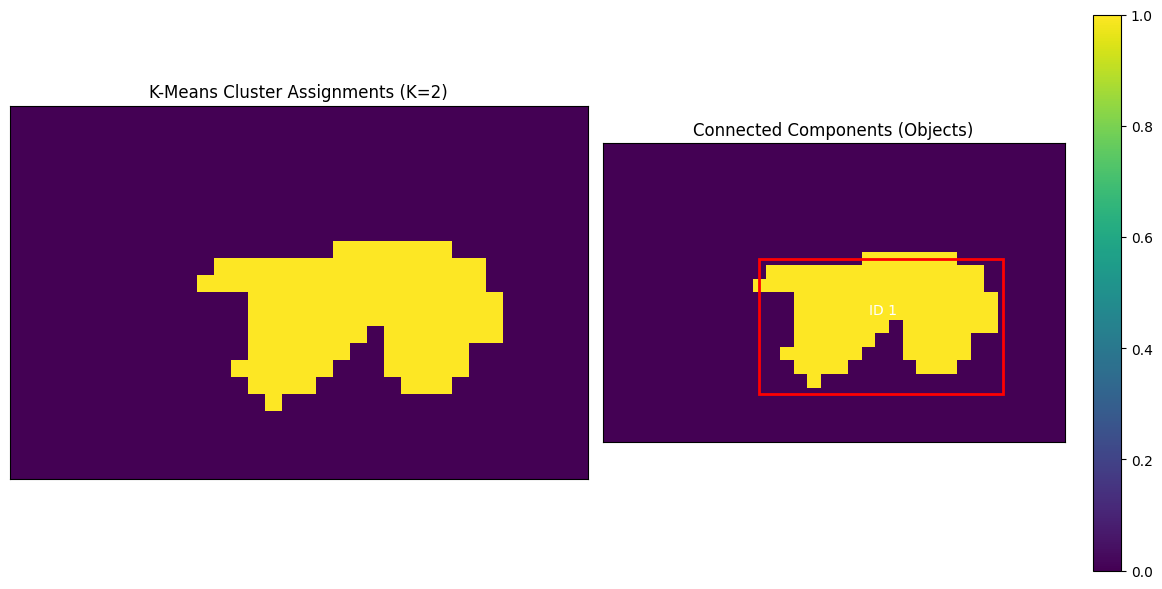

In [59]:
### START CODE HERE ###
from skimage.measure import regionprops 

class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state=None):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        # Reshape HOG features for K-means input
        hog_features_array = np.array(self.hog_extractor.hog_features)
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10) # n_init is set to 'auto' by default in newer scikit-learn, but explicit can be good.
        kmeans.fit(hog_features_array)
        
        # Get cluster assignments
        cluster_assignments = kmeans.labels_

        # Reshape cluster assignments into a grid
        num_rows, num_cols = self.hog_extractor.get_num_grid()
        self.cluster_array = cluster_assignments.reshape(num_rows, num_cols)

        # Identify connected components
        self.all_labels = measure.label(self.cluster_array)


    def plot_cluster_and_labels(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot cluster assignments
        ax1 = axes[0]
        # Use a colormap that visually separates the clusters, similar to the example image
        ax1.imshow(self.cluster_array, cmap='viridis') 
        ax1.set_title(f'K-Means Cluster Assignments (K={self.n_clusters})')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Plot connected components
        ax2 = axes[1]
        im = ax2.imshow(self.all_labels, cmap='viridis') 
        ax2.set_title('Connected Components (Objects)')
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        props = regionprops(self.all_labels)
        if not props:
            print("No objects found.")
            return

        # ✅ เลือก object ที่ใหญ่ที่สุด (ตาม area)
        largest_obj = max(props, key=lambda p: p.area)
        min_row, min_col, max_row, max_col = largest_obj.bbox

        # วาด bounding box เฉพาะ object ที่ใหญ่ที่สุด
        rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                            edgecolor='red', facecolor='none', linewidth=2)
        ax2.add_patch(rect)

        # ✅ Optional: วาง label ตรงกลาง object
        cy, cx = largest_obj.centroid
        ax2.text(cx, cy, f'ID {largest_obj.label}', color='white', ha='center', va='center', fontsize=10)

        # Add a colorbar to the second plot, similar to the example
        fig.colorbar(im, ax=ax2)

        plt.tight_layout()
        plt.show()
        

    def get_bounding_boxes(self):
        if self.all_labels is None:
            raise ValueError("Clustering ยังไม่ถูกประมวลผล กรุณาเรียก perform_clustering() ก่อน")

        props = regionprops(self.all_labels)
        self.bounding_boxes = []

        for prop in props:
            min_row, min_col, max_row, max_col = prop.bbox
            self.bounding_boxes.append((min_row, min_col, max_row, max_col))

        return self.bounding_boxes

    
### END CODE HERE ###
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=1)
kmeans_cluster.plot_cluster_and_labels()

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [60]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    img_copy = image.copy()
    for obj_id, (start_x, start_y), (end_x, end_y) in bboxes:
        cv2.rectangle(img_copy, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
        cv2.putText(img_copy, str(obj_id), (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

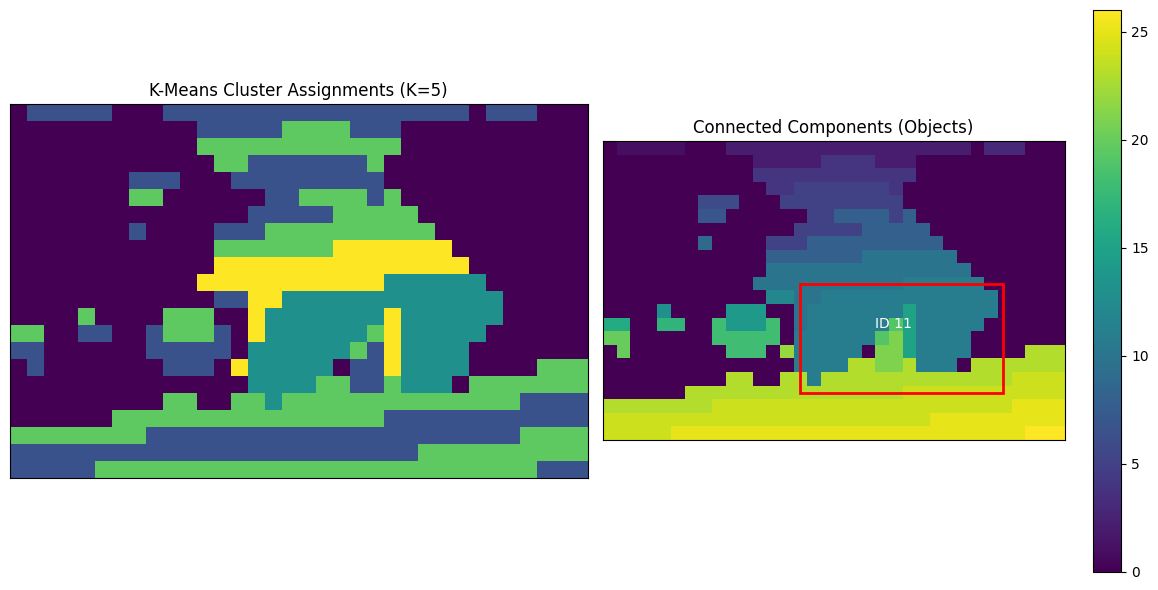

ValueError: too many values to unpack (expected 3)

In [61]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=5, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None



### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


## **Answer** 
1. ถ้า kernel size ใหญ่เกินไป อาจทำให้วัตถุเบลอเกินไปจนขอบไม่ชัด 



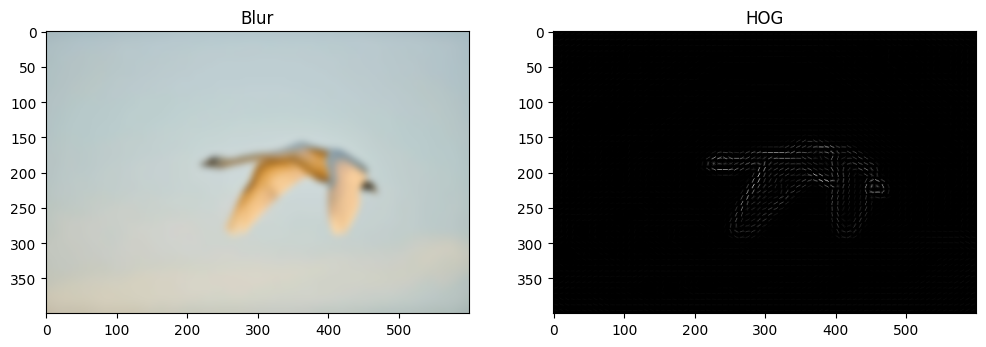

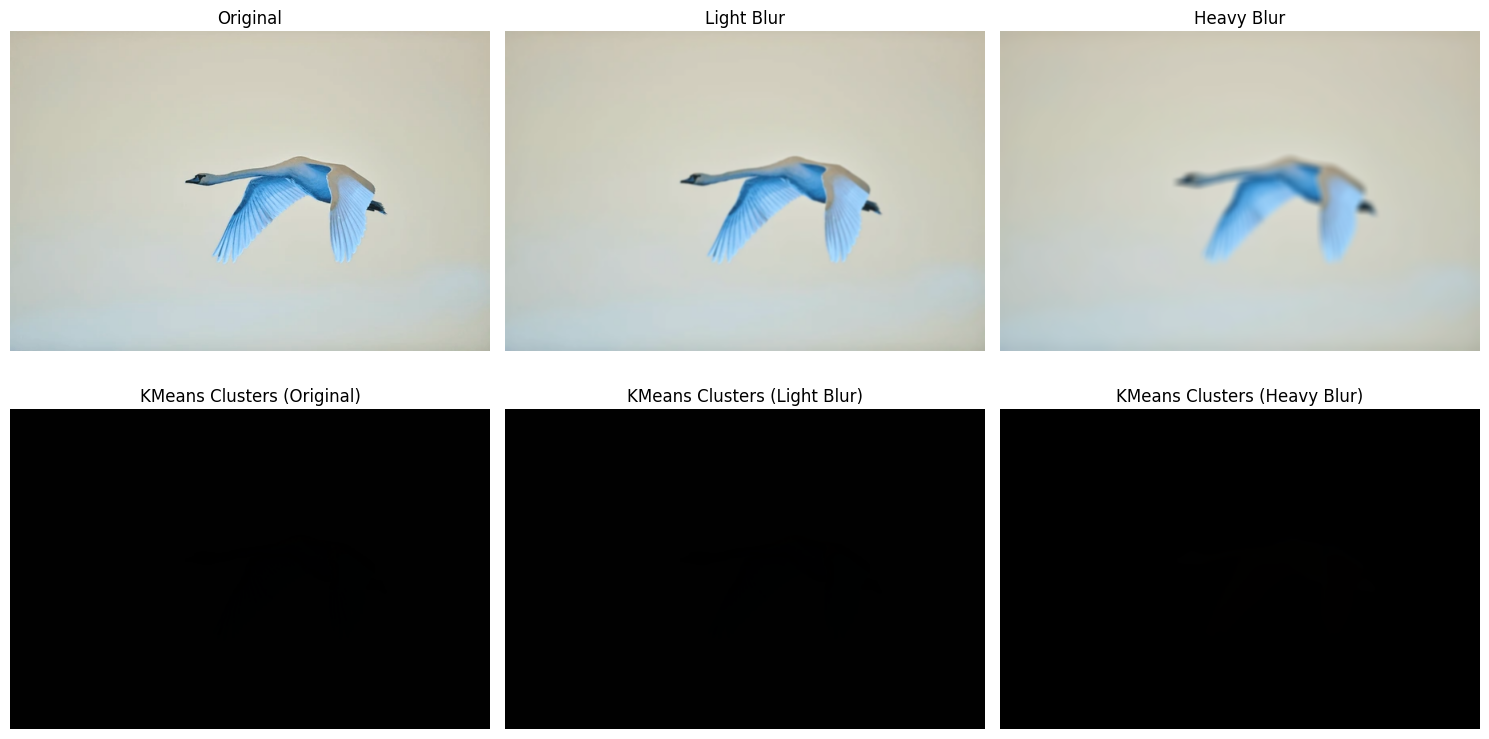

In [ ]:
image2 = cv2.imread('image.jpg', cv2.COLOR_BGR2GRAY)

# Gaussian blur แบบต่างๆ
no_blur = image2.copy()
light_blur = cv2.GaussianBlur(np.array(image2), (5, 5), 1.0)
heavy_blur = cv2.GaussianBlur(np.array(image2), (11, 11), 5.0)

# blurry_image = cv2.GaussianBlur(np.array(image), (25, 25), 5)
# fd, hog_image = hog(
#     blurry_image,
#     orientations=9,
#     pixels_per_cell=(8, 8),
#     cells_per_block=(2, 2),
#     visualize=True,
#     channel_axis=-1
# )


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(blurry_image)
axs[0].set_title('Blur')

axs[1].imshow(hog_image, cmap='gray')
axs[1].set_title('HOG')

# ฟังก์ชันสำหรับ clustering
def kmeans_cluster(img, k=2):
    features = img.reshape(-1, 1).astype(np.float32)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(features)
    clustered = kmeans.labels_.reshape(img.shape)
    return clustered

# ทำ KMeans กับทั้ง 3 ภาพ
cluster_no_blur = kmeans_cluster(no_blur)
cluster_light_blur = kmeans_cluster(light_blur)
cluster_heavy_blur = kmeans_cluster(heavy_blur)

# แสดงผล
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

titles = ['Original', 'Light Blur', 'Heavy Blur']
images = [no_blur, light_blur, heavy_blur]
clusters = [cluster_no_blur, cluster_light_blur, cluster_heavy_blur]

for i in range(3):
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].set_title(titles[i])
    axes[0, i].axis('off')

    axes[1, i].imshow(clusters[i], cmap='viridis')
    axes[1, i].set_title(f'KMeans Clusters ({titles[i]})')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

2. pixels per cell เล็ก ทำให้จับวัตถุขนาดเล็กได้ แต่ใช้เวลาในการคำนวณนานขึ้น pixels per cell ใหญ่ ได้ภาพรวมของวัตถุ เหมาะกับการจับวัตถุขนาดใหญ่ คำนวณเร็วกว่า ส่วน cells per block ใหญ่ ทำให้ block ครอบคลุมพื้นที่กว้าง cells per block เล็ก รองรับการเปลี่ยนแปลงเฉพาะจุดมากขึ้น

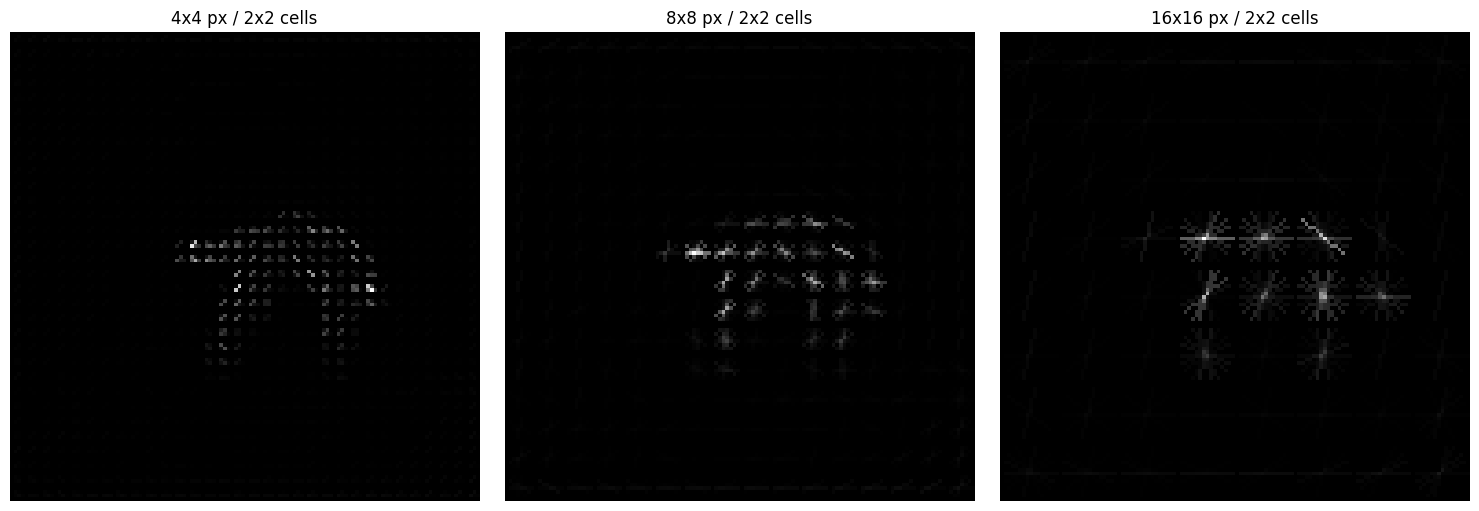

In [ ]:
image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128))

configs = [
    {"pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "title": "4x4 px / 2x2 cells"},
    {"pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "title": "8x8 px / 2x2 cells"},
    {"pixels_per_cell": (16, 16), "cells_per_block": (2, 2), "title": "16x16 px / 2x2 cells"},
]


fig, axes = plt.subplots(1, len(configs), figsize=(15, 5))
for ax, cfg in zip(axes, configs):
    fd, hog_image = hog(image,
                        pixels_per_cell=cfg["pixels_per_cell"],
                        cells_per_block=cfg["cells_per_block"],
                        visualize=True,
                        block_norm='L2-Hys')
    
    ax.imshow(hog_image, cmap='gray')
    ax.set_title(cfg["title"])
    ax.axis('off')

plt.tight_layout()
plt.show()


3. small tiles ได้การจัดกลุ่มที่ละเอียดและแม่นยำขึ้น มีจำนวนกลุ่มมาก ส่วน large tiles อาจรวมวัตถุหลายอย่างไว้ในก้อนเดียว เพราะข้อมูลถูกลดรายละเอียดบางส่วนลง และมีจำนวนกลุ่มน้อยกว่า

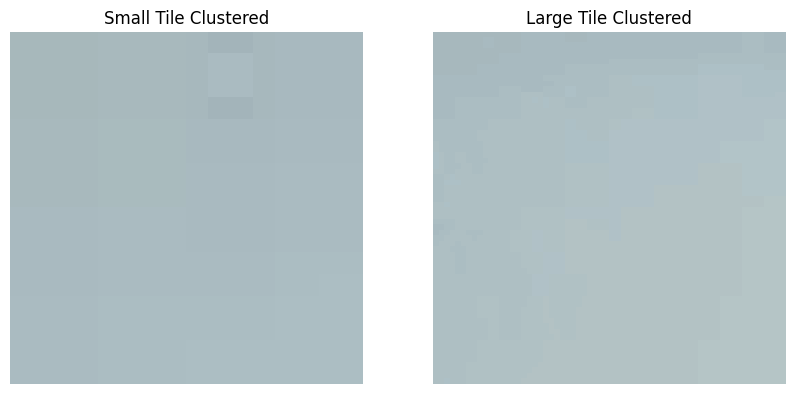

In [64]:
def extract_tiles(image, tile_size):
    h, w, _ = image.shape
    tiles = []
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = image[y:y+tile_size, x:x+tile_size]
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)
    return tiles

def cluster_tile_colors(tile, n_clusters=3):
    pixels = tile.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    clustered = clustered.reshape(tile.shape).astype(np.uint8)
    return clustered

# โหลดภาพตัวอย่าง
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# กำหนดขนาดไทล์เล็กและใหญ่
small_tile_size = 16
large_tile_size = 64

# แบ่งภาพเป็นไทล์เล็กและใหญ่
small_tiles = extract_tiles(image, small_tile_size)
large_tiles = extract_tiles(image, large_tile_size)

# แสดงผลลัพธ์การจัดกลุ่มสีของไทล์ตัวอย่างไทล์แรกของแต่ละขนาด
small_tile_clustered = cluster_tile_colors(small_tiles[0], n_clusters=10)
large_tile_clustered = cluster_tile_colors(large_tiles[0], n_clusters=10)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Small Tile Clustered")
plt.imshow(small_tile_clustered)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Large Tile Clustered")
plt.imshow(large_tile_clustered)
plt.axis('off')

plt.show()
